In [2]:
import praw, sqlite3, OAuth2Util, time, pandas as pd, numpy as np, matplotlib.pyplot as plt, datetime as dt
import statsmodels.api as sm
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import spearmanr
from scipy.stats import pearsonr
%matplotlib inline
from tqdm import tqdm
from time import gmtime


/Users/Mapkyc/anaconda/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
/Users/Mapkyc/anaconda/lib/python3.5/site-packages/statsmodels/base/wrapper.py:94: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  argspec = inspect.getargspec(func)
/Users/Mapkyc/anaconda/lib/python3.5/site-packages/numpy/lib/utils.py:99: DeprecationWarning: `scipy.linalg.calc_lwork` is deprecated!

calc_lwork was an internal module in Scipy and has been removed.

Several functions in scipy.linalg.lapack have *_lwork variants
that perform the lwork calculation (from Scipy >= 0.15.0), or
allow passing in LWORK=-1 argument to perform the computation.


  warnings.warn(depdoc, DeprecationWarning)


In [ ]:
#This Notebook collects comments made at www.reddit.com/r/mma and then analyses them in various ways

#Collect subreddit comments through the reddit API

#Using OAuth2Util exclusively as authentication allows 1 API call per second as opposed to the default 1 every 2 seconds
def mk_praw():
    r = praw.Reddit(user_agent, api_request_delay=1, timeout=60*5)
    o = OAuth2Util.OAuth2Util(r, server_mode=True)
    o.refresh(force=True)
    return (r, o)


user_agent = "Popular fighters 1.0 by /u/pop-fighters"

r, _ = mk_praw()

# determine target subreddit, and time period to collect for
sub_name = "mma"
collect_limit = None
#times are in unix timestap, use an epoch converter to specify times
range_limit1 = 1456761606  #closer to now
range_limit2 = 1456704060  #further in the past
step = 86400               #86400 seconds = 1 day
com_list = []              #used to count the number of comments collected


#tqdm allows for time per iteration / predicted time to completion etc
for chunk_search_start in tqdm(list(range(range_limit2,range_limit1,step))): #currently starts further back in time and steps forward

    start = chunk_search_start
    end = chunk_search_start + step - 1

    print(start)

    query = "timestamp:{}..{}".format(start, end)
    
    #search query syntax='cloudsearch' allows for more than 1000 search results to be supplied (an API limitation)
    subr = r.search(query= query, subreddit=sub_name, sort='new',limit=collect_limit,
                    syntax='cloudsearch')
    
    #connect to sqlite3 db that is already in existance (N.B. in this exercise about 2 million comments are collects, much more and 
    # sqlite3 will become too slow to use.)
    
    connect_db = sqlite3.connect('mma_comments.db')
    c = connect_db.cursor()

    for submission in subr:
        
        #print for keeping track of progress (API call rate limits the speed of script so printing doesn't have much impact on performance)
        print(submission.short_link)

        #opens collapsed comment trees - each open is an extra api call
        submission.replace_more_comments(limit=None, threshold=0) 
        
        # flattens comment trees for ease of collection
        flat_comments = praw.helpers.flatten_tree(submission.comments,depth_first=True,nested_attr='replies')

        for comment in flat_comments:
            try:
                #pass
                x = (comment.author.name, comment.created_utc, comment.body, comment.permalink,
                comment.is_root, comment.score, comment.ups, comment.id,submission.created_utc, submission.id) #attributes to collect

            except AttributeError as e: #exception for deleted comments
                print(e)
                #pass

            else:

                try:
                    #comment table in mma_comments.db called .... 'comments'
                    c.execute('INSERT INTO comments VALUES(?,?,?,?,?,?,?,?,?,?)', x)
                    #pass

                #have set the unique comment id as a primary key in the comment table,  so no duplicate comments are taken.
                except (sqlite3.IntegrityError) as e: 
                    #pass

                else:

                    #saves db so that data isn't lost if connection fails- again the API calls are the bottleneck so this wont affect speed
                    connect_db.commit() 
                    com_list.append(x)


In [3]:
%%time
# looking at the data
connect_db = sqlite3.connect('mma_comments.db')
c = connect_db.cursor()

#collect desired attributes from db
c.execute('SELECT comm_id, com_date, sub_date, sub_id, text, username  FROM comments ORDER BY sub_date ASC;')
prelim = c.fetchall()
col_names =['comm_id','comm_date', 'sub_date','sub_id','text', 'user']

# create pandas DataFrame with column names from col_names (order of names must match order fetched)
df = pd.DataFrame(prelim, columns=col_names)
#convert unix timestamps into readable format
df['comm_date'] = pd.to_datetime(df['comm_date'],unit='s') #'s' denotes that the timestamp is in units of seconds, not ms or micro etc

df['sub_date'] = pd.to_datetime(df['sub_date'],unit='s')
#set comment date as the datetime index for the DF. allows for easy manipulation of timeseries data
prelim2 = df.set_index('comm_date')
#convert to USA time as event dates are for USA
prelim2.index = prelim2.index.tz_localize('UTC').tz_convert('US/Pacific')

CPU times: user 35.3 s, sys: 8.31 s, total: 43.6 s
Wall time: 52.6 s


/Users/Mapkyc/anaconda/lib/python3.5/site-packages/dateutil/rrule.py:470: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)


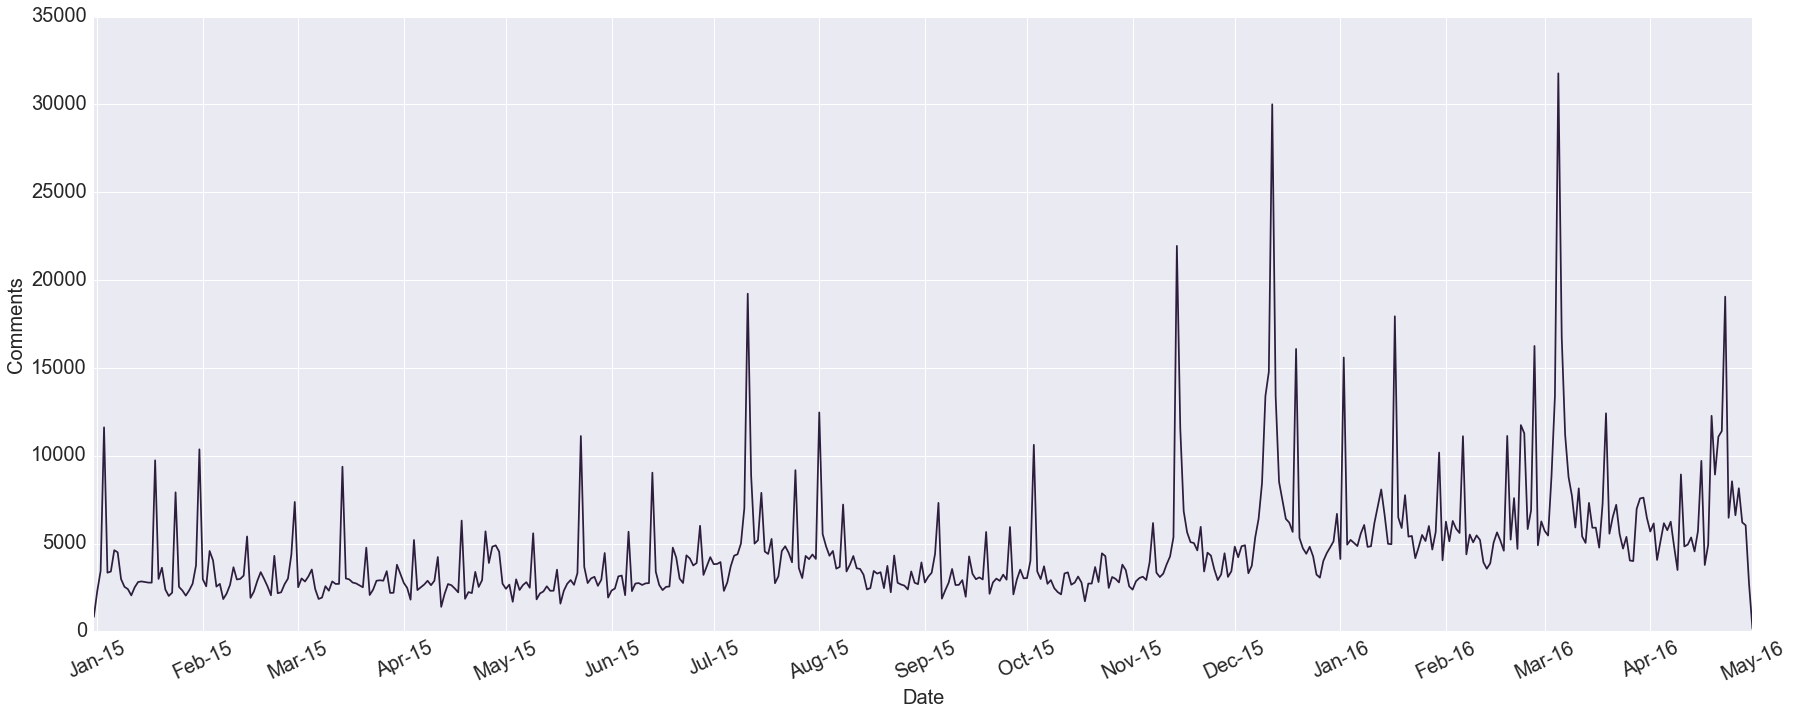

In [4]:
#group DF by date (days) and count the number of comments (in this case entries) in each day
total_comment_plot = prelim2["text"].groupby(prelim2.index.date).count()

#plots the number of comments per day over the time period
sns.set_style('darkgrid')
_,b = sns.cubehelix_palette(2)
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1)
plt.plot(total_comment_plot.index, total_comment_plot, color=b)
plt.xlabel("Date", fontsize=20)
plt.ylabel("Comments",fontsize=20)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))   
plt.xticks(fontsize=20, rotation=25)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig("overall_comments_day.png")

In [5]:
#create df containing daily summed comments
comment_count = total_comment_plot.to_frame()
comment_count.columns = ['Comments']

#calculate 7 day rolling median in as a rudimentry way of removing baseline number of posts
roll_med = pd.rolling_median(comment_count["Comments"], 7, center=True)
#replace n/a values at start and end of series
roll_med = roll_med.fillna(method='backfill').fillna(method='ffill')


/Users/Mapkyc/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_median is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=True).median()


In [40]:
#read in event dates from csv file
event_dates = pd.read_csv('fullevents.csv')
#set as datetime.date object, if this step isn't done the next step does not work due to what look 
#like rounding/offset errors in the time component of the data
event_dates["date"] = pd.DatetimeIndex(event_dates["date"]).date
event_dates = event_dates.set_index("date")

#select only dates on which events took place from the daily comment counts df
event_counts = comment_count.loc[comment_count.index.isin(event_dates.index)]

# add new column to df containing events
event_dates["comments"] = event_counts.copy()
event_dates



,Event,comments
date,,
2016-04-23,UFC 197: Jones vs. Saint Preux,19056
2016-04-16,UFC on Fox: Teixeira vs. Evans,9708
2016-04-10,UFC Fight Night: Rothwell vs. dos Santos,8935
2016-03-19,UFC Fight Night: Hunt vs. Mir,12416
2016-03-05,UFC 196: McGregor vs. Diaz,31768
2016-02-27,UFC Fight Night: Silva vs. Bisping,16248
2016-02-21,UFC Fight Night: Cowboy vs. Cowboy,7590
2016-02-06,UFC Fight Night: Hendricks vs. Thompson,11111
2016-01-30,UFC on Fox: Johnson vs. Bader,10180


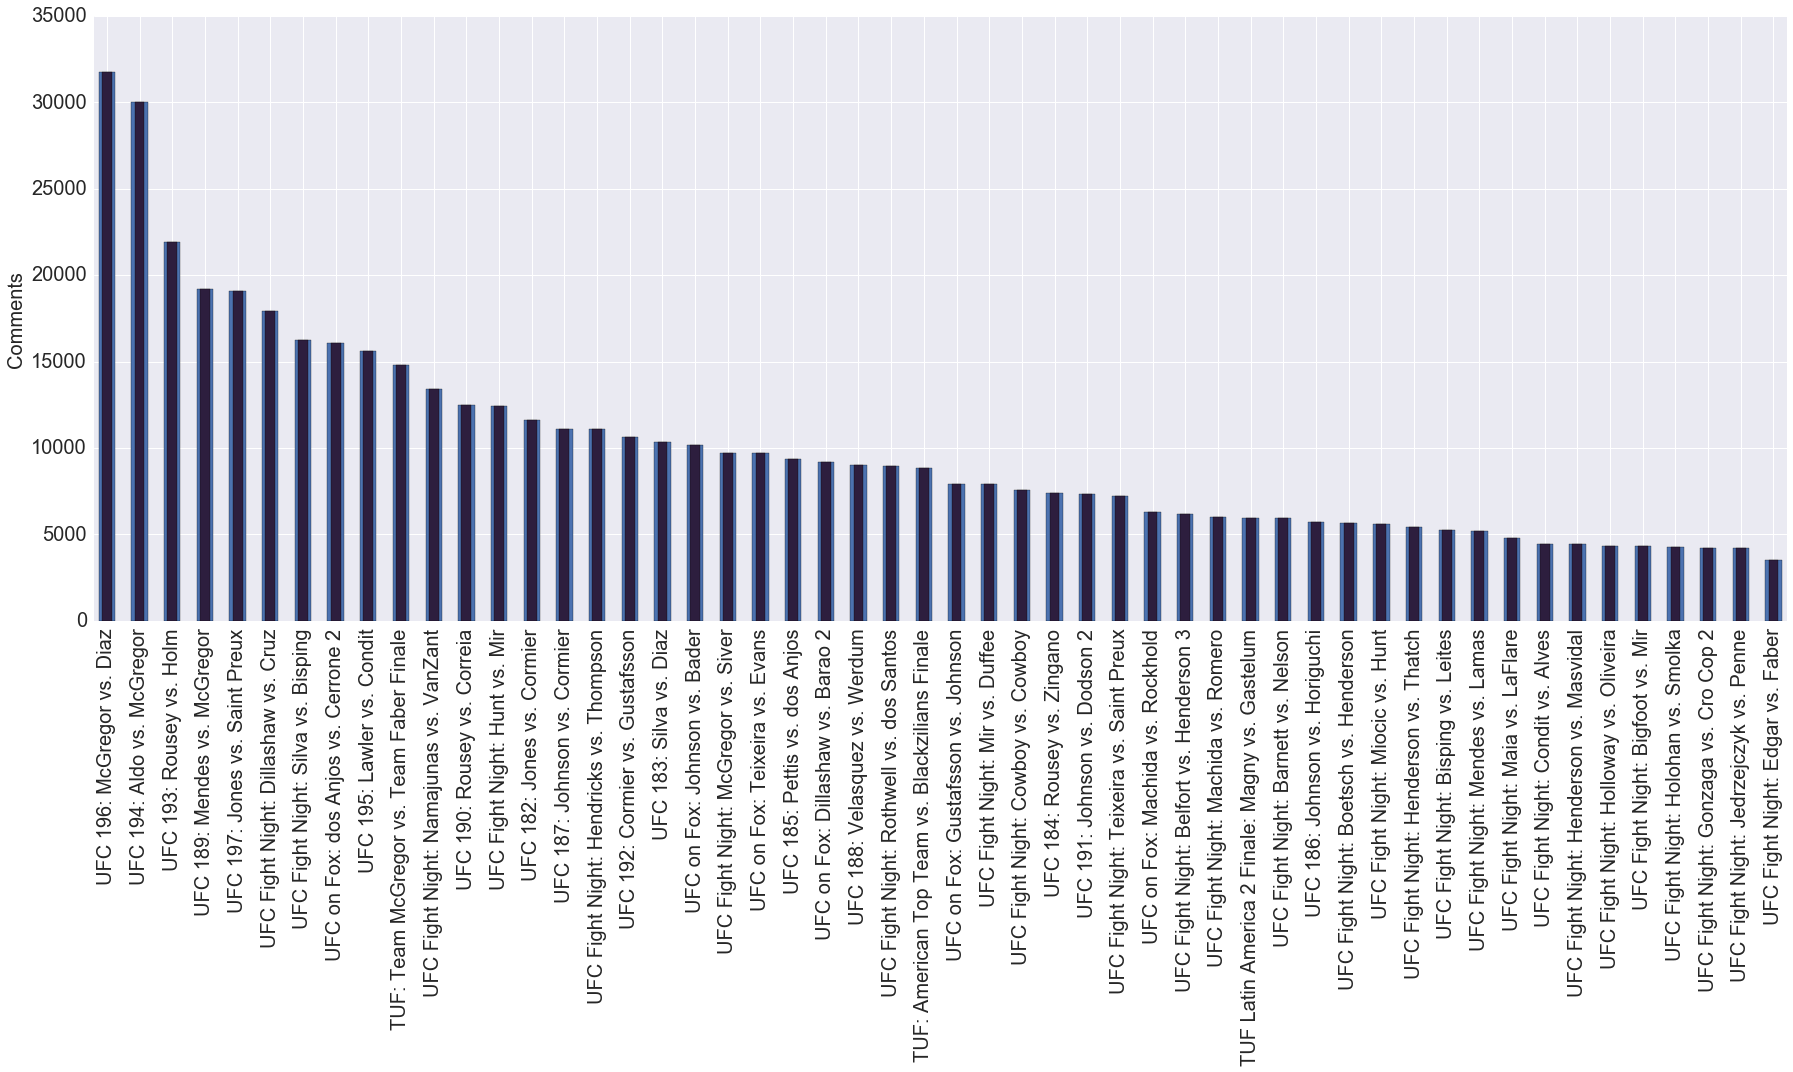

In [32]:
#plot all events in order descending from most comments to least comments
#seborn colour palette
sns.set_style('darkgrid')
_,b = sns.cubehelix_palette(2)
fig = plt.figure(figsize=(25,10)) 

event_dates = event_dates.sort_values(['comments'], ascending=False)
event_dates.plot(kind='bar')


g = event_dates.comments.plot(kind='bar', width=0.3, color=b, 
                              xticks=event_dates.index,fontsize=20, figsize=(25,15))

g.set_xticklabels(list(event_dates["Event"]), fontsize=20)
g.set_xlabel('')
g.legend_.remove()
g.set_ylabel("Comments", fontsize=20)


plt.tight_layout()
plt.show()

In [41]:
#select the numbered/pay per view (PPV) UFC events (e.g. UFC 182 vs UFC Fight Nights)
num_events = pd.read_csv('numbered-events.csv')
num_events["date"] = pd.DatetimeIndex(num_events["date"]).date
num_events["PPV"] = pd.to_numeric(num_events["PPV"])
num_events = num_events.set_index('date')

#select PPV events and add them to dataframe
PPV_vs_coms = event_dates.loc[event_dates.index.isin(num_events.index)]
PPV_vs_coms["PPV"] = num_events["PPV"].copy()

PPV_vs_coms= PPV_vs_coms.sort_values(["comments"], ascending= False)

PPV_vs_coms


/Users/Mapkyc/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Event,comments,PPV
date,,,
2016-03-05,UFC 196: McGregor vs. Diaz,31768,1500000
2015-12-12,UFC 194: Aldo vs. McGregor,30005,1200000
2015-11-14,UFC 193: Rousey vs. Holm,21945,1100000
2015-07-11,UFC 189: Mendes vs. McGregor,19224,825000
2016-04-23,UFC 197: Jones vs. Saint Preux,19056,0
2016-01-02,UFC 195: Lawler vs. Condit,15592,300000
2015-08-01,UFC 190: Rousey vs. Correia,12465,900000
2015-01-03,UFC 182: Jones vs. Cormier,11615,800000
2015-05-23,UFC 187: Johnson vs. Cormier,11122,375000


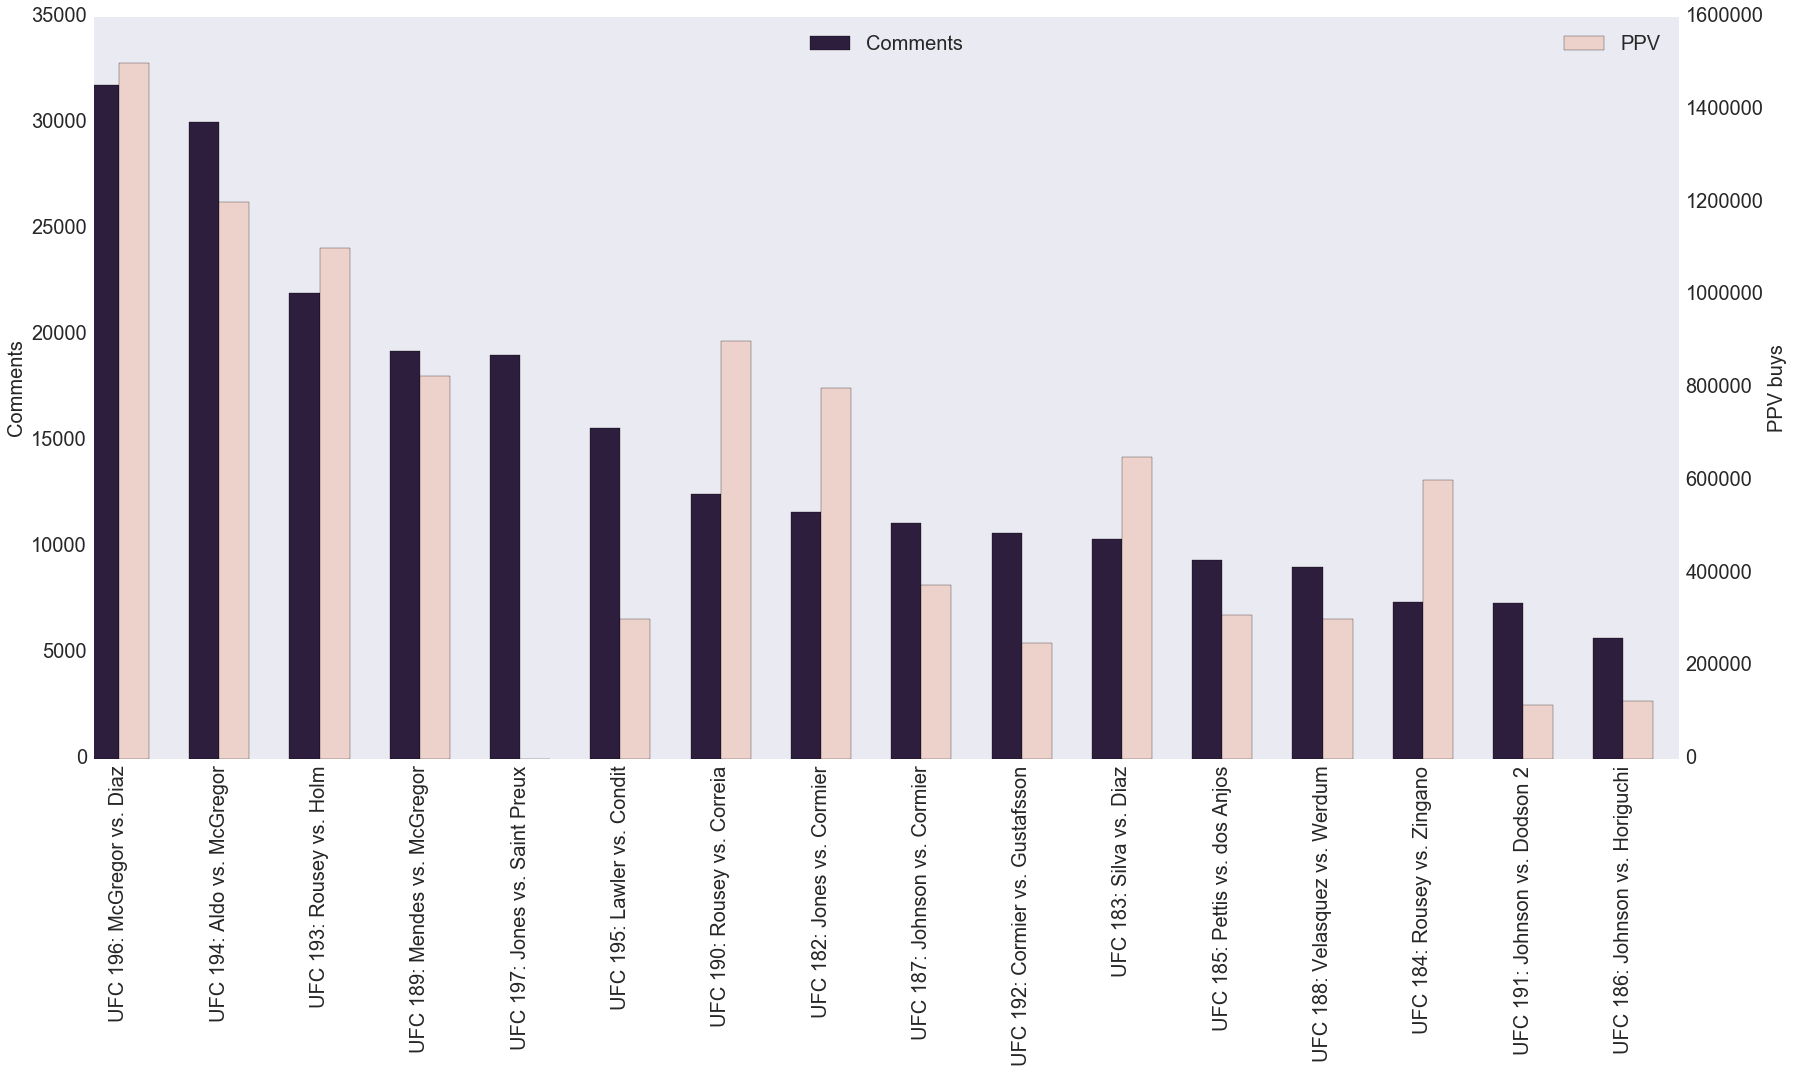

In [42]:
#print double bar chart of comments and PPV buys associated with a UFC event
#set colour palette
sns.set_style('dark')
a,b = sns.cubehelix_palette(2)

fig = plt.figure(figsize=(25,15)) # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

g = PPV_vs_coms.comments.plot(kind='bar',ax=ax, position=1, width=0.3, color=b, xticks=PPV_vs_coms.index, fontsize=20)
h = PPV_vs_coms.PPV.plot(kind='bar',ax=ax2, position=0,width=0.3, color=a, fontsize=20)

#change xticks to event names rather than dates
g.set_xticklabels(list(PPV_vs_coms["Event"]), fontsize=20)
g.set_xlabel("")
g.legend(("Comments",), fontsize=20, loc='upper center')
g.set_ylabel("Comments", fontsize=20)
h.set_ylabel("PPV buys", fontsize=20)
h.legend(("PPV",),  fontsize=20, loc='upper right')

fig.tight_layout()



In [43]:
# momentum is the cumulative winstreak for an event. each fighters winstreaks are calculated and summed.
# previous fight a win = +1, previous two fights are losses = -2, no contest = 0
#these have been manually calculated
momentum = [24, 62, 14, 14, 16, 39, 24, 36, 11, 19, 19, 7, 22, -2, 17, 17]
PPV_vs_coms["momentum"] = momentum.copy()
#adding 2 removed -ve values which messes up the next plot. Not ideal solution but it works
PPV_vs_coms["momentum"] = PPV_vs_coms["momentum"] + 2


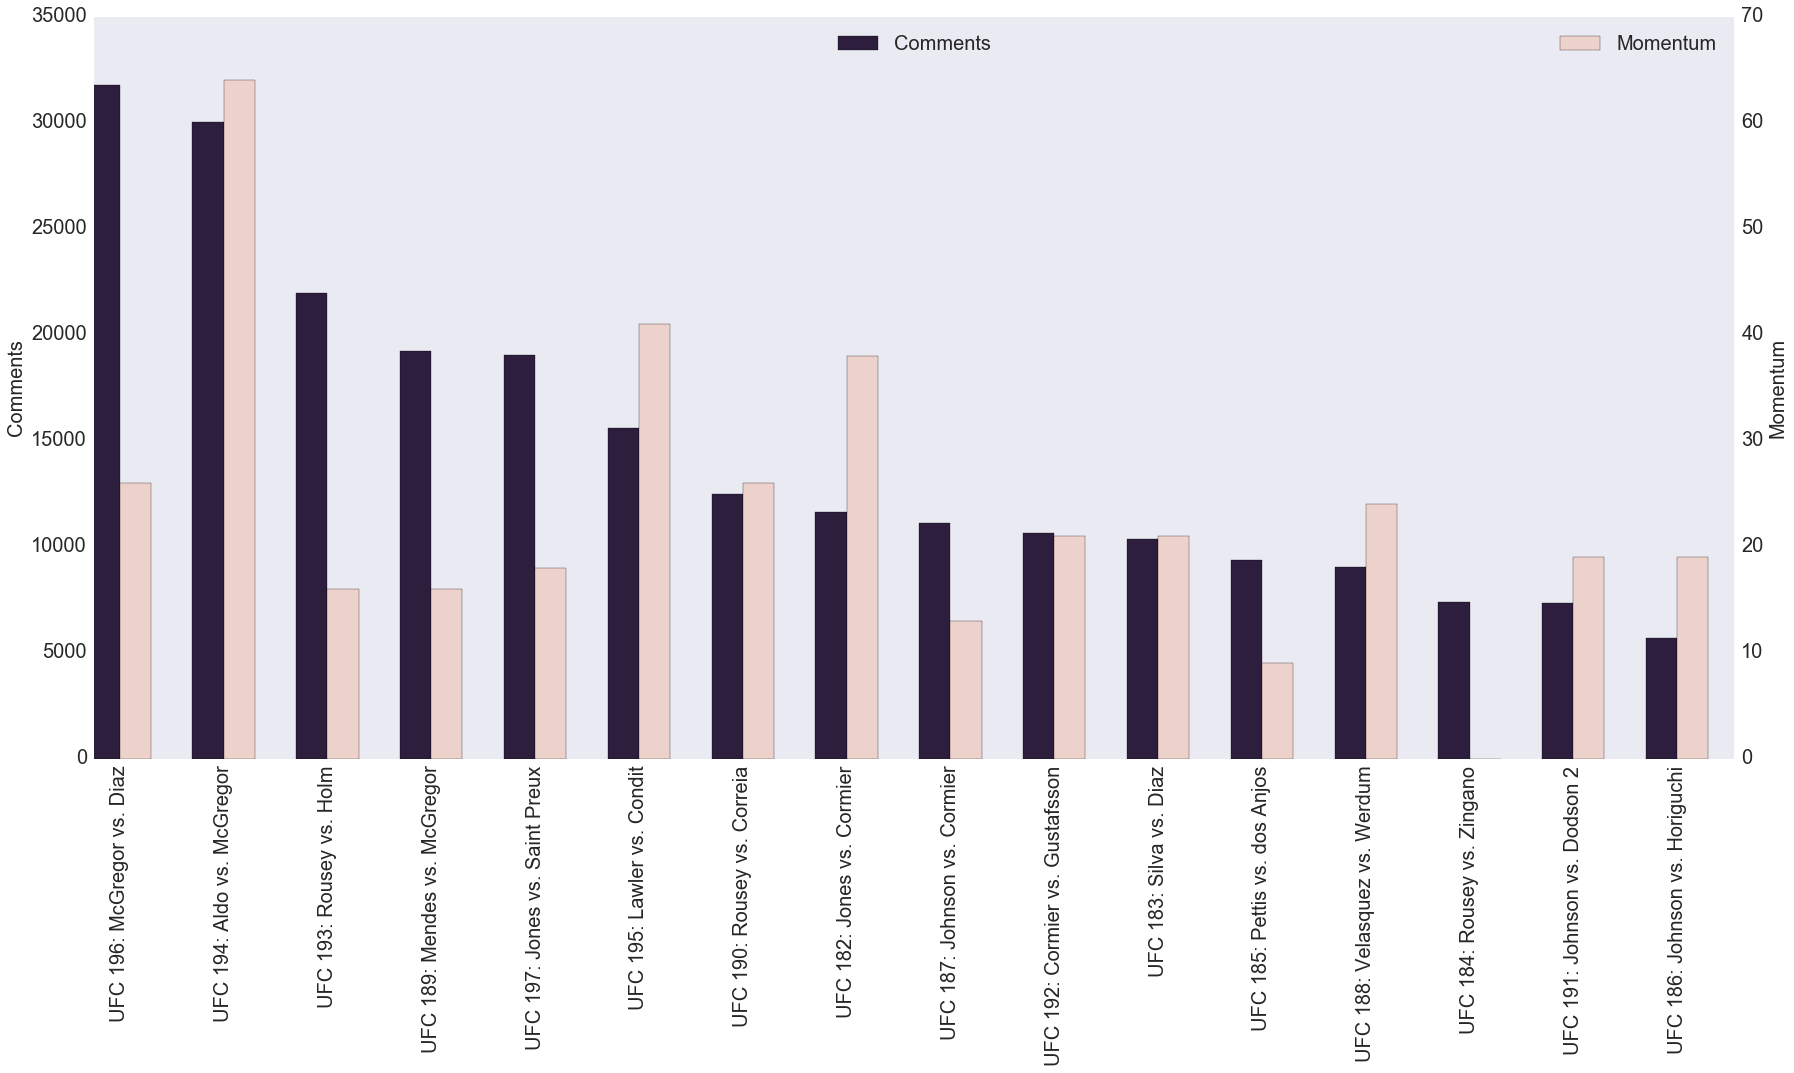

In [45]:
# plot comments vs momentum similar to above

sns.set_style('dark')
a,b = sns.cubehelix_palette(2)
fig = plt.figure(figsize=(25,15)) # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes

ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
g = PPV_vs_coms.comments.plot(kind='bar',ax=ax, position=1, width=0.3, color= b, xticks=PPV_vs_coms.index, fontsize=20)
h = PPV_vs_coms.momentum.plot(kind='bar',ax=ax2, position=0,width=0.3, color=a, fontsize=20)
g.set_xticklabels(list(PPV_vs_coms["Event"]), fontsize=20)
g.set_xlabel("")
g.legend(("Comments",), fontsize=20, loc ='upper center')
g.set_ylabel("Comments", fontsize=20)
h.set_ylabel("Momentum", fontsize=20)
h.legend(("Momentum",),  fontsize=20, loc='upper right')

fig.tight_layout()

In [48]:
#calculate correlation of comments and momentum
spearmanr(PPV_vs_coms["comments"], PPV_vs_coms["momentum"])


SpearmanrResult(correlation=0.35545877367733891, pvalue=0.17665551423579293)

In [47]:
#calculate correlation of comments and momentum
spearmanr(PPV_vs_coms["comments"], PPV_vs_coms["PPV"])

SpearmanrResult(correlation=0.65195013970857574, pvalue=0.0062063377073894683)

In [49]:
#This cell takes around 40 mins to run
#Doing a basic count of fighter mentions in the comments collected 

#list of tuples that contains the names/ nicknames/ common mispellings of top 10 fighters + the champ in each weight category 
#(official UFC ranking from 2016-04-11)
tuple_list = [("demetrious","mighty mouse"),                     #Mens Flyweight
              ("Benavides", "Benavidez"),
              (["Cejudo"]),
              (["Dodson"]),
              ("Jussier","Formiga"),
              ("mccall","mcall","uncle creepy"),
              ("kyoji","horiguchi"),
              (["Moraga"]),
              (["Makovsky"]),
              (["wilson Reis"]),
              (["Dustin Ortiz"]),
              ("Dominick","Cruz","The dominator","domin8or"),              #Mens Bantamweight
              ("TJ","Dillashaw","snake in the grass","snek","thrillashaw"),
              ("faber","california kid","urijah"),
              (["assunacao"]),
              ("Aljamain","sterling","funk master"),
              ("renan","barao"),
              ("michael mcdonald", "mayday"),
              ("Almeida","Thominhas"),
              ("caraway","Mr.tate","kid lightning"),
              ("Takeya","Mizugaki"),
              (["Johnny Eduardo"]),
              ("conor","connor","mcg","notorious"),                       #Mens Featherweight
              ("aldo","jose"),
              ("frankie", "edgar"),
              ("mendes","chad"),
              ("max holloway", "Holloway"),
              ("ricardo","lamas","the bully"),
              ("cub","swanson"),
              ("Oliveria","do bronx"),
              (["bermudez"]),
              ("jeremy stephens","lil' heathen"),
              (["Hacran"]),
              ("Dos Anjos", "RDA", "rafael"),                            # Lightweight
              (["Alvarez"]),
              ("khabib","nurmagomedov","habib","the eagle"),
              ("pettis","showtime"),
              ("tony ferguson","el cucuy"),
              ("diaz","nate","nick"),
              (["michael Johnson"]),
              ("beneil","dariush"),
              ("edson","barboza"),
              ("cerrone", "cowboy"),
              ("poirier","the diamond"),
              ("lawler", "robbie","robby","ruthless"),                  #Welterweight
              ("rory","macdonald", "red king", "canadian psycho"),
              ("Stephen Thompson", "wonderboy", "wonder boy"),
              ("tyrone","woodley"),
              ("carlos","condit","natural born killer"),
              ("Hendricks","Johny","Big rig"),
              ("damian","maia"),
              (["Magny"]),
              ("Matt Brown","the immortal"),
              ("dong","hyun","kim","the stun gun"),
              ("tarec","saffiedine"),
              (["rockhold"]),                                            #Middleweight
              ("Weidman","The chris","the all-american"),
              ("Jacare","souza","the crocodile"),
              ("vitor","belfort","trtitor","the phenom"),
              ("Bisping","the count"),
              ("lyoto","machida","the dragon"),
              ("anderson", "silva", "the spider"),
              (["whittaker"]),
              ("gegard","mousasi"),
              (["tim kennedy"]),
              ("uriah","prime time"),
              ("daniel","cormier","cormeir","DC"),                 #light heavyweight
              ("jon jones", "jbj", "jj", "bones"),
              ("anthony Johnson","rumble"),
              ("gustafsson","the mauler"),
              ("glover","teixeria"),
              ("Bader","darth"),
              ("Ovince","preux","OSP"),
              ("Rashad","evans","suga"),
              ("mauricio","rua","shogun"),
              (["Manuwa"]),
              ("Antonio","rogerio","big nog"),
              ("werdum","fabricio"),                            #Heavyweight
              ("Cain","valasquez"),
              ("stipe","miocic"),
              ("Alistair","overeem","the reem"),
              (["Rothwell"]),
              ("Dos santos","JDS","cigano"),
              ("andrei","arlovski","the bulldog"),
              ("travis","Browne","hapa"),
              ("Mark Hunt","hunt","hunto","super samoan"),
              ("barnett","the warmaster"),
              ("Frank Mir","Mir"),
              ("Joanna","Jedrzejczyk"),                       #womens strawweight
              ("claudia","gadelha"),
              ("carla","esparza"),
              ("rose","namajunas"),
              ("tecia","torres","the tiny tornado"),
              (["penne"]),
              ("valerie","letourneau"),
              ("paige","vanzant","van zant","PVZ","12 guage"),
              ("waterson","Karate hottie"),
              ("Maryna","moroz","iron lady"),
              ("Karolina","kowalkiewicz"),
              ("miesha","meisha","tate","cupcake"),            #womens bantamweight
              ("holly","holm","preachers daughter","preacher's daughter"),
              ("ronda","rhonda","honda","rousey","housey"),
              (["zigano"]),
              ("amanda","nunes","the lioness"),
              ("julianna","pena","the venezuelan"),
              ("sara","mcmann","mcman"),
              (["jessica eye"]),
              ("bethe","correia","pitbull"),
              ("carmouche","girlrilla"),
              (["sarah Kaufman"])]


#search the comment text for fighter mentions
#np.logical_or.reduce means that even if there are multiple mentions of the same fighter 
#in each comment it only counts once if a comment mentions more than one fighter it is 
#counted more than once produces comments named after the first string in the list of 
#strings with True in rows for columns where a fighter was mentioned and false otherwise
def add_figher_mentions(df, tuple_list):

    for string_tuple in tuple_list:
        col_name = string_tuple[0]    
     
        new_col = np.logical_or.reduce([df['text'].str.contains(string, case=False) for string in string_tuple])
        
        df[col_name] = new_col
        
    return df
    
    

#add columns to the DF
fighter_cols = add_figher_mentions(prelim2, tuple_list)


In [52]:
#create a dictionary named using the first string in each list of strings in tuple_list, with an unevaluated function
#np.sum as the value
sum_cols = { tup[0]: np.sum for tup in tuple_list }
all_fighter_cols = [tup[0] for tup in tuple_list]

#group the DF by users and count the different fighter mentions by each user in separate columns
fighter_counts = fighter_cols.groupby(['user']).agg(sum_cols).astype(int)
#count the total mentions of fighters, sort by users with the most fighter mentions
fighter_counts["total fighter mentions"] = fighter_counts.apply(lambda x : np.sum([x[c] for c in all_fighter_cols]), axis = 1)
fighter_counts = fighter_counts.sort_values(["total fighter mentions"], ascending=False)

#total comments (including those with no mentions) made by a user
fighter_counts["total_comments"] = fighter_cols.groupby(['user'])['text'].count()

fighter_counts[:30]

,vitor,bethe,uriah,stipe,Matt Brown,khabib,Dustin Ortiz,Alistair,dong,barnett,...,glover,diaz,Dominick,anderson,Bader,Dodson,zigano,faber,total fighter mentions,total_comments
user,,,,,,,,,,,,,,,,,,,,,
Csardonic1,26,46,16,66,5,35,1,6,41,11,...,17,293,62,212,18,22,0,45,5836,6733
VinceOnAPlane,44,155,14,47,17,58,0,58,28,17,...,5,188,43,115,39,44,0,28,5314,6162
kapsama,110,32,7,19,23,37,0,33,25,19,...,13,160,20,119,36,6,0,44,4771,5850
BabycakesJunior,34,18,11,18,47,100,1,17,33,13,...,13,344,128,94,15,11,0,49,4473,3513
hughie-d,6,2,4,1,1,41,0,0,4,0,...,0,268,18,53,1,1,0,52,4273,3229
cyberslick188,62,18,10,23,3,94,0,40,43,18,...,14,345,56,169,42,17,0,35,4128,5720
evilf23,120,17,10,18,25,8,0,25,21,33,...,10,223,36,173,40,11,0,19,3383,5349
Whydidideletemyaccou,58,4,0,23,3,38,0,9,12,5,...,22,140,42,131,32,10,1,18,3111,4338
ninjarapter4444,23,9,8,59,21,16,0,28,5,42,...,6,119,59,107,11,13,0,41,3095,3726


In [53]:
wc_mentions = fighter_cols.groupby(fighter_cols.index.date).agg(sum_cols).astype(int)
wc_mentions.index = pd.to_datetime(wc_mentions.index,unit='s')

# add columns that are the sum of the fighter mentions in each weight class

#define weight classes
Weight_classes = [("MensFly",["demetrious","Benavides","Cejudo","Dodson","Jussier","mccall","kyoji","Moraga","Makovsky","wilson Reis",
                              "Dustin Ortiz"]),
                  ("MensBantam",["Dominick","TJ","faber","assunacao","Aljamain","renan","michael mcdonald","Almeida","caraway","Takeya",
                                 "Johnny Eduardo"]),
                  ("MensFeather",["conor","aldo","frankie","mendes","max holloway","ricardo","cub","Oliveria","bermudez","jeremy stephens",
                                  "Hacran"]),
                  ("Lightweight",["Dos Anjos","Alvarez","khabib","pettis","tony ferguson","diaz","michael Johnson","beneil","edson","cerrone",
                                  "poirier"]),
                  ("Welterweight",["lawler","rory","Stephen Thompson","tyrone","carlos","Hendricks","damian","Magny","Matt Brown","dong",
                                   "tarec"]),
                  ("Middleweight",["rockhold","Weidman","Jacare","vitor","Bisping","lyoto","anderson","whittaker","gegard","tim kennedy",
                                      "uriah"]),
                  ("Light Heavyweight",["daniel","jon jones","anthony Johnson","gustafsson","glover","Bader","Ovince","Rashad","mauricio","Manuwa",
                                        "Antonio"]),
                  ("Heavyweight",["werdum","Cain","stipe","Alistair","Rothwell","Dos santos","andrei","travis","Mark Hunt","barnett",
                                   "Frank Mir"]),
                  ("WomensStraw",["Joanna","claudia","carla","rose","tecia","penne","valerie","paige","waterson","Maryna",
                                  "Karolina"]),
                  ("WomensBantam",["miesha","holly","ronda","zigano","amanda","julianna","sara","jessica eye","bethe","carmouche",
                                   "sarah Kaufman"])]


# names column with first element in tuple, identifies colums to sum with second element in tuple ( a list of fighter names)
for cat_name, fighter in Weight_classes:

    wc_mentions[cat_name] = wc_mentions.apply(lambda x: np.sum([x[fighter] for fighter in fighter]), axis=1)

wc_mentions[:30] #The streamgraph found at (https://s3-eu-west-1.amazonaws.com/streamgraph1/index.html) uses the data from wc_mentions

,vitor,bethe,uriah,stipe,Matt Brown,khabib,Dustin Ortiz,Alistair,dong,barnett,...,MensFly,MensBantam,MensFeather,Lightweight,Welterweight,Middleweight,Light Heavyweight,Heavyweight,WomensStraw,WomensBantam
2014-12-31,9,0,0,0,1,0,0,1,3,5,...,1,5,17,30,12,47,123,25,3,12
2015-01-01,5,0,14,0,4,0,0,0,4,11,...,5,23,266,123,229,117,230,45,5,39
2015-01-02,30,1,10,2,5,4,0,6,9,27,...,10,52,241,212,121,231,757,147,7,34
2015-01-03,16,0,3,6,1,43,1,5,14,24,...,88,55,214,704,94,192,1882,218,1,71
2015-01-04,8,1,3,4,1,9,1,5,1,7,...,44,27,140,237,57,208,815,198,26,64
2015-01-05,15,0,7,1,11,23,0,7,12,7,...,16,65,168,497,209,198,419,135,30,46
2015-01-06,27,1,5,4,4,19,1,51,5,1,...,6,33,98,426,56,138,454,434,6,107
2015-01-07,45,0,1,0,2,21,0,45,8,2,...,2,25,114,285,49,281,431,402,8,91
2015-01-08,36,0,1,2,1,2,0,18,1,5,...,8,19,79,188,85,350,295,229,3,76
2015-01-09,16,0,4,3,0,3,0,5,4,3,...,15,58,257,257,72,414,222,87,3,42
